# Imports and Installation Packages

Below is the necessary instalation packages needed to run this notebook.

In [1]:
pip install pandas pyarrow matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from pandas.tseries.holiday import USFederalHolidayCalendar as calander

# Data Loading

In [3]:

# Path to the directory where all your Parquet files are stored
path = '/Users/md/Desktop/python_project/parquet_files'  # Update the path accordingly

# Dictionary to store row counts from each file
row_counts = {}

# Read each Parquet file and count the rows
all_files = glob.glob(path + "/*.parquet")
dataframes = []
for file in all_files:
    temp_df = pd.read_parquet(file)
    row_counts[file] = len(temp_df)
    dataframes.append(temp_df)

# Concatenate all dataframes into a single DataFrame
df = pd.concat(dataframes)


In [4]:
# Total row count from the DataFrame
total_rows_df = len(df)

# Total row count from individual files
total_rows_files = sum(row_counts.values())

# Compare the counts
print(f"Total rows in DataFrame: {total_rows_df}")
print(f"Expected total rows from files: {total_rows_files}")
print(f"Row count match: {total_rows_df == total_rows_files}")


Total rows in DataFrame: 38310226
Expected total rows from files: 38310226
Row count match: True


In [5]:
# Printing row counts for each file
for file, count in row_counts.items():
    print(f"{file}: {count} rows")


/Users/md/Desktop/python_project/parquet_files/yellow_tripdata_2023-06.parquet: 3307234 rows
/Users/md/Desktop/python_project/parquet_files/yellow_tripdata_2023-07.parquet: 2907108 rows
/Users/md/Desktop/python_project/parquet_files/yellow_tripdata_2023-05.parquet: 3513649 rows
/Users/md/Desktop/python_project/parquet_files/yellow_tripdata_2023-04.parquet: 3288250 rows
/Users/md/Desktop/python_project/parquet_files/yellow_tripdata_2023-08.parquet: 2824209 rows
/Users/md/Desktop/python_project/parquet_files/yellow_tripdata_2023-11.parquet: 3339715 rows
/Users/md/Desktop/python_project/parquet_files/yellow_tripdata_2023-01.parquet: 3066766 rows
/Users/md/Desktop/python_project/parquet_files/yellow_tripdata_2023-10.parquet: 3522285 rows
/Users/md/Desktop/python_project/parquet_files/yellow_tripdata_2023-09.parquet: 2846722 rows
/Users/md/Desktop/python_project/parquet_files/yellow_tripdata_2023-12.parquet: 3376567 rows
/Users/md/Desktop/python_project/parquet_files/yellow_tripdata_2023-02

We need to make sure that our data contains only values from 2023

In [6]:
df = df[(df['tpep_pickup_datetime'].dt.year == 2023) & (df['tpep_dropoff_datetime'].dt.year == 2023)]

In [7]:
len(df)

38309599

we can see that some records were dropped as they were not within 2023

In [8]:
df.head(1)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,airport_fee
0,1,2023-06-01 00:08:48,2023-06-01 00:29:41,1.00,3.40,1.00,N,140,238,1,21.90,3.50,0.50,6.70,0.00,1.00,33.60,2.50,0.00,NaN


# Dataset Initial Look

In the section below we take a look at the overall dataset for 2023, look at the null values and determine the next steps for cleaning, preprocessing and feature engineering.

## Feature Description Based on Data Dictionary:
Below is the features description based on official documentation from NYC taxi and limo services:

| Field Name                  | Description |
|-----------------------------|-------------|
| `VendorID`                  | A code indicating the TPEP provider that provided the record. <br> 1 = Creative Mobile Technologies, LLC; <br> 2 = VeriFone Inc. |
| `tpep_pickup_datetime`      | The date and time when the meter was engaged. |
| `tpep_dropoff_datetime`     | The date and time when the meter was disengaged. |
| `Trip_distance`             | The elapsed trip distance in miles reported by the taximeter. |
| `PULocationID`              | TLC Taxi Zone in which the taximeter was engaged. |
| `DOLocationID`              | TLC Taxi Zone in which the taximeter was disengaged. |
| `Passenger_count`           | The number of passengers in the vehicle. This is a driver-entered value. |
| `RateCodeID`                | The final rate code in effect at the end of the trip. <br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br> 4 = Nassau or Westchester <br> 5 = Negotiated fare <br> 6 = Group ride |
| `Store_and_fwd_flag`        | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka "store and forward," because the vehicle did not have a connection to the server. <br> Y = store and forward trip <br> N = not a store and forward trip |
| `Payment_type`              | A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br> 2 = Cash <br> 3 = No charge <br> 4 = Dispute <br> 5 = Unknown <br> 6 = Voided trip |
| `Fare_amount`               | The time-and-distance fare calculated by the meter. |
| `Extra`                     | Miscellaneous extras and surcharges. Currently, this only includes the 0.50 and 1 rush hour and overnight charges. |
| `MTA_tax`                   | 0.50 MTA tax that is automatically triggered based on the metered rate in use. |
| `Improvement_surcharge`     | 0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
| `Tip_amount`                | Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| `Tolls_amount`              | Total amount of all tolls paid in trip. |
| `Total_amount`              | The total amount charged to passengers. Does not include cash tips. |
| `Congestion_Surcharge`      | Total amount collected in trip for NYS congestion surcharge. |
| `Airport_fee`               | 1.25 for pick up only at LaGuardia and John F. Kennedy Airports. |


### Descriptive Stats

In [9]:
# Assuming 'df' is your DataFrame
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,airport_fee
count,38309599.00,37000277.00,38309599.00,37000277.00,38309599.00,38309599.00,38309599.00,38309599.00,38309599.00,38309599.00,38309599.00,38309599.00,38309599.00,38309599.00,37000277.00,34005292.00,2994985.00
mean,1.74,1.37,4.09,1.64,165.18,163.95,1.18,19.52,1.56,0.49,3.52,0.59,0.98,28.46,2.26,0.14,0.11
std,0.44,0.89,241.25,7.43,64.00,69.86,0.56,75.73,2.45,0.11,4.15,2.20,0.20,77.13,0.80,0.48,0.36
min,1.00,0.00,0.00,1.00,1.00,1.00,0.00,-959.90,-39.17,-0.50,-411.00,-91.30,-1.00,-982.95,-2.50,-1.75,-1.25
25%,1.00,1.00,1.04,1.00,132.00,113.00,1.00,9.30,0.00,0.50,1.00,0.00,1.00,15.95,2.50,0.00,0.00
50%,2.00,1.00,1.79,1.00,162.00,162.00,1.00,13.50,1.00,0.50,2.80,0.00,1.00,21.00,2.50,0.00,0.00
75%,2.00,1.00,3.40,1.00,234.00,234.00,1.00,21.90,2.50,0.50,4.41,0.00,1.00,30.72,2.50,0.00,0.00
max,6.00,9.00,345729.44,99.00,265.00,265.00,5.00,386983.63,10002.50,53.16,4174.00,665.56,1.00,386987.63,2.75,1.75,1.25


Here's a structured markdown description and explanation of the descriptive statistics for your dataset, formatted appropriately for inclusion in your project notebook:

---

## Descriptive Statistics Overview

This section provides a detailed summary of the data related to NYC taxi trips. Below is the interpretation of each column's statistics:

### General Statistics

- **Count**: Indicates the total number of non-missing entries for each feature.
- **Mean**: Represents the average value across all entries for each feature.
- **Std (Standard Deviation)**: Shows the amount of variation or dispersion from the average.
- **Min (Minimum)**: The smallest value found in each feature.
- **25% (1st Quartile)**: A quarter of the entries are below this value.
- **50% (Median)**: The middle value when the data is ordered from least to greatest.
- **75% (3rd Quartile)**: Three-quarters of the entries are below this value.
- **Max (Maximum)**: The largest value found in each feature.

### Feature-Specific Statistics

- **VendorID**:
  - Values range from 1 to 6, indicating different TPEP providers.
  - Most trips are evenly split between the providers.

- **Passenger Count**:
  - The number of passengers ranges from 0 to 9 per trip.
  - The majority of trips carry just one passenger.

- **Trip Distance**:
  - Distances range from 0 to 345,729.44 (likely indicating outliers or data errors).
  - The average trip is approximately 4.09 miles, though the median value is lower at 1.79 miles, which suggests that there are some very long trips skewing the average higher.

- **RatecodeID**:
  - A majority of trips use the standard rate (code 1), with some outliers using code as high as 99 (which may indicate special rates or data errors).

- **PULocationID** and **DOLocationID** (Pickup and Dropoff Location IDs)**:
  - Both feature IDs range from 1 to 265, which corresponds to pre-defined taxi zones in NYC.
  - The average pickup and dropoff locations are around the mid-160s, but this wide range suggests that taxis service a broad area of the city.

- **Payment Type**:
  - Ranges from 0 to 5, indicating different forms of payment.
  - Most trips are paid with type 1, which based on our data dictionary indicate payments made by credit card.

- **Fare Amount**:
  - Fares range from -959.90 to 386,983.63, showing that there are likely errors or outliers in the data as negative fares and excessively high fares are not feasible.

- **Extra Charges** (like late-night or rush hour fees)**:
  - Values range from -39.17 to 10,002.50, also indicating potential data entry errors or outliers.

- **MTA Tax**:
  - Ranges from -0.50 to 53.16, with most trips showing the standard MTA tax of 0.50.

- **Tip Amount**:
  - Tips range from -411 to 4,174, with a mean tip of approximately 3.52.

- **Tolls Amount**:
  - Toll amounts have a wide range from -91.30 to 665.56, again suggesting some outliers or errors.

- **Improvement Surcharge**:
  - This has a smaller range of values, mostly being the standard surcharge of 1.00, but with a minimum indicating an erroneous entry at -1.00.

- **Total Amount**:
  - The total amount paid, including all surcharges and fees, ranges from -982.95 to 386,987.63, which includes potential outliers or incorrect charges.

- **Congestion Surcharge**:
  - Reflects additional charges during peak times in congested areas, with most trips incurring the standard congestion surcharge of 2.50.

- **Airport Fee**:
  - Not all entries have airport fees, but for those that do, they range from -1.75 to 1.75, with negative values indicating potential data errors.

### Observations and Actionable Insights

The dataset contains some inconsistencies and potential errors, particularly in `trip_distance`, `fare_amount`, `extra`, `mta_tax`, `tip_amount`, `tolls_amount`, and `total_amount`. Before using this data for further analysis or model training, it's essential to perform data cleaning to remove or correct these outliers and erroneous entries. This will ensure the integrity and reliability of any conclusions drawn or predictive models developed from this dataset.


# Data Cleaning 

as described above our data has significant outliers, negative and 0 values in order to be able to proceed with feature enginnering and modeling we need to adress this issues. 

### Categorical Columns Overview and Filtering 

In [4]:
# List of categorical columns based on your data dictionary
categorical_columns = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type','PULocationID','DOLocationID','payment_type']

# Print unique values in each categorical column
for column in categorical_columns:
    # Ensure the column is treated as categorical
    df[column] = df[column].astype('category')
    
    # Print unique values
    unique_values = df[column].unique()
    print(f"Unique values in {column}: {unique_values}")


Unique values in VendorID: [1, 2, 6]
Categories (3, int64): [1, 2, 6]


/Users/md/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


Unique values in RatecodeID: [1.00, 2.00, 4.00, 99.00, 5.00, 3.00, 6.00, NaN]
Categories (7, float64): [1.00, 2.00, 3.00, 4.00, 5.00, 6.00, 99.00]
Unique values in store_and_fwd_flag: ['N', 'Y', NaN]
Categories (2, object): ['N', 'Y']
Unique values in payment_type: [1, 2, 4, 3, 5, 0]
Categories (6, int64): [0, 1, 2, 3, 4, 5]
Unique values in PULocationID: [140, 50, 138, 100, 137, ..., 27, 30, 105, 176, 110]
Length: 263
Categories (263, int64): [1, 2, 3, 4, ..., 262, 263, 264, 265]
Unique values in DOLocationID: [238, 151, 97, 244, 234, ..., 187, 2, 99, 110, 105]
Length: 262
Categories (262, int64): [1, 2, 3, 4, ..., 262, 263, 264, 265]
Unique values in payment_type: [1, 2, 4, 3, 5, 0]
Categories (6, int64): [0, 1, 2, 3, 4, 5]


### VendorID

In [5]:
vendor_id_6_rows = df[df['VendorID'] == 6]
vendor_id_6_rows

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,airport_fee
3207546,6,2023-06-01 05:06:15,2023-06-01 06:06:23,NaN,4.68,NaN,NaN,265,77,0,17.91,0.00,0.50,0.00,0.00,0.30,18.71,NaN,NaN,NaN
3207616,6,2023-06-01 06:06:44,2023-06-01 06:06:54,NaN,2.71,NaN,NaN,265,188,0,15.20,0.00,0.50,0.00,0.00,0.30,16.00,NaN,NaN,NaN
3207700,6,2023-06-01 07:06:50,2023-06-01 08:06:43,NaN,6.47,NaN,NaN,265,233,0,30.03,0.00,0.50,0.00,0.00,0.30,30.83,NaN,NaN,NaN
3207704,6,2023-06-01 07:06:26,2023-06-01 08:06:26,NaN,10.74,NaN,NaN,265,75,0,68.82,0.00,0.50,0.00,0.00,0.30,69.62,NaN,NaN,NaN
3207862,6,2023-06-01 07:06:59,2023-06-01 08:06:32,NaN,11.96,NaN,NaN,265,224,0,41.97,0.00,0.50,0.00,0.00,0.30,42.77,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403143,6,2023-03-31 19:03:52,2023-03-31 19:03:22,NaN,1.16,NaN,NaN,265,232,0,44.20,0.00,0.50,0.00,0.00,0.30,45.00,NaN,NaN,NaN
3403257,6,2023-03-31 20:03:53,2023-03-31 20:03:07,NaN,14.33,NaN,NaN,265,130,0,75.00,0.00,0.00,0.00,0.00,0.00,75.00,NaN,NaN,NaN
3403316,6,2023-03-31 20:03:29,2023-03-31 20:03:33,NaN,10.92,NaN,NaN,265,213,0,38.71,0.00,0.50,0.00,0.00,0.30,39.51,NaN,NaN,NaN
3403418,6,2023-03-31 21:03:14,2023-03-31 21:03:29,NaN,7.20,NaN,NaN,265,152,0,33.20,0.00,0.50,0.00,0.00,0.30,34.00,NaN,NaN,NaN


As we can see vendor ID has 8668 rosw with value of 6 which is not within our pre-defined categories, as this number is small relative to our dataset size we can remove all rows with vendorID of 6.

In [6]:
df_filtered = df[df['VendorID'] != 6]

# You can compare the sizes before and after to see how many rows were removed
print("Original DataFrame size:", df.shape)
print("New DataFrame size after removing VendorID 6:", df_filtered.shape)

Original DataFrame size: (38310226, 20)
New DataFrame size after removing VendorID 6: (38301558, 20)


In [7]:
df = df_filtered

### RateCodeID

Typical ratecode ids based on our dictionary are from 1-6 we see the value of 99 in our categories, based on our research 99 used to be part of this category and data dictionary is not including this type means it was either removed or tehre was an error when compiling data dictionary or for some other reaseon it remains, generally 99 meant missing or unknown we will keep it for our purpouses. 

This is ratecode descriptions based on older data dict: 
1= Standard rate
2=JFK
3=Newark
4=Nassau or Westchester
5=Negotiated fare
6=Group ride
99 = Null/unknown

In [15]:
rateCode_99 = df[df['RatecodeID'] == 99]

In [16]:
rateCode_99

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,airport_fee
671,1,2023-06-01 00:26:21,2023-06-01 00:26:38,1.00,0.00,99.00,N,78,78,1,47.50,0.00,0.50,0.00,0.00,1.00,49.00,0.00,0.00,NaN
1315,1,2023-06-01 00:02:39,2023-06-01 00:06:33,1.00,0.90,99.00,N,67,67,1,15.20,0.00,0.50,0.00,0.00,1.00,16.70,0.00,0.00,NaN
1632,1,2023-06-01 00:00:48,2023-06-01 00:45:56,1.00,0.00,99.00,N,86,42,1,54.20,0.00,0.50,0.00,6.55,1.00,62.25,0.00,0.00,NaN
1633,1,2023-06-01 00:54:30,2023-06-01 01:11:37,1.00,0.00,99.00,N,42,7,1,23.20,0.00,0.50,0.00,6.55,1.00,31.25,0.00,0.00,NaN
1751,1,2023-06-01 00:01:33,2023-06-01 00:19:23,1.00,5.30,99.00,N,256,157,1,25.50,0.00,0.50,0.00,0.00,1.00,27.00,0.00,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312910,1,2023-03-31 23:18:35,2023-04-01 00:05:35,1.00,8.10,99.00,N,140,47,1,32.50,0.00,0.50,0.00,6.55,1.00,40.55,0.00,0.00,NaN
3313401,1,2023-03-31 23:49:20,2023-04-01 00:11:19,1.00,0.00,99.00,N,92,236,1,31.20,0.00,0.50,0.00,6.55,1.00,39.25,0.00,0.00,NaN
3314378,1,2023-03-31 23:19:45,2023-03-31 23:46:56,1.00,6.00,99.00,N,181,149,1,26.50,0.00,0.50,0.00,0.00,1.00,28.00,0.00,0.00,NaN
3314904,1,2023-03-31 23:08:04,2023-03-31 23:42:41,1.00,0.00,99.00,N,122,42,1,39.20,0.00,0.50,0.00,6.55,1.00,47.25,0.00,0.00,NaN


There is 213477 counts of ratecode 99 which means for thir trips the ratecode is unknown.

### Payment Type 

for the current year dictionary we see that the values start from [1, 2, 4, 3, 5, 0] and based on current year data dictionary the atcual results do not correlate as the ctaegories are from 1 to 6, however based on previous years data dictionaries the categories were : 
"0= Flex Fare trip
1= Credit card
2= Cash
3= No charge
4= Dispute
5= Unknown
6= Voided trip"

We can assume that this is still relavant and trips with 0 are of flex fare and all voided trips were removed from the dataset 

In [17]:
zero_payment_types = df[df['payment_type'] == 0]
print("Analysis of records with payment_type 0:")
zero_payment_types.describe(include='all')  # Adjust to focus on relevant fields

Analysis of records with payment_type 0:


/var/folders/4d/8tkcz58x0md0_v7fj12j6ht80000gn/T/ipykernel_7662/3398748685.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  zero_payment_types.describe(include='all')  # Adjust to focus on relevant fields


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,airport_fee
count,1300654.00,1300654,1300654,0.00,1300654.00,0,0,1300654.00,1300654.00,1300654.00,1300654.00,1300654.00,1300654.00,1300654.00,1300654.00,1300654.00,1300654.00,0.00,0.00,0.00
unique,2.00,1221708,1222536,NaN,NaN,0,0,258.00,259.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2.00,2023-04-01 20:51:00,2023-05-11 17:14:00,NaN,NaN,NaN,NaN,236.00,138.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,791931.00,8,7,NaN,NaN,NaN,NaN,48221.00,45949.00,1300654.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2023-01-01 00:00:00,2023-01-01 00:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2023-12-31 23:53:49,2023-12-31 23:59:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,18.53,NaN,NaN,NaN,NaN,NaN,22.23,0.18,0.50,2.79,0.60,1.00,29.59,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1253.60,NaN,NaN,NaN,NaN,NaN,15.17,0.76,0.06,3.48,2.26,0.05,18.50,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,-184.76,-39.17,-0.50,-10.76,0.00,0.00,-154.94,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,0.61,NaN,NaN,NaN,NaN,NaN,12.83,0.00,0.50,0.00,0.00,1.00,18.91,NaN,NaN,NaN


Yes, your explanation regarding the `payment_type` values makes sense and is a logical approach to reconciling the discrepancy between the data and the data dictionary descriptions. Your analysis acknowledges the differences in category definitions across different years and provides a sensible assumption that can be validated or adjusted as more information becomes available or through further analysis.

Here’s how you can enhance your explanation and ensure clarity:

### Enhanced Markdown Explanation for Notebook

---

### Payment Type Analysis

In our current dataset, the observed `payment_type` values are [1, 2, 4, 3, 5, 0], which do not directly align with the categories specified in this year's data dictionary, which range from 1 to 6. Notably, the category '6' (Voided trip) is absent, and '0' appears as an additional category not documented for this year.

From historical data dictionaries, the `payment_type` categories have been listed as:
- 0 = Flex Fare trip
- 1 = Credit card
- 2 = Cash
- 3 = No charge
- 4 = Dispute
- 5 = Unknown
- 6 = Voided trip

Given the discrepancies, a plausible explanation is that the coding has remained consistent with previous years where '0' represented "Flex Fare trips." The absence of '6' in the dataset suggests that all "Voided trips" might have been excluded from the current dataset, potentially during pre-processing stages or as a result of data governance policies.

#### Implications for Data Analysis
- **Assumption Validation**: We will treat '0' as "Flex Fare trip" for the purpose of our analyses. This assumption is based on historical categorization, and should future data dictionaries or additional information from the data provider suggest otherwise, revisions may be necessary.
- **Handling Absent Categories**: The lack of '6' in the dataset should be noted, and any analysis on `payment_type` should account for the potential non-inclusion of voided trips.
- **Data Cleaning and Usage**: With these assumptions, data cleaning steps will incorporate '0' as a valid category, and analysis involving payment types will reflect these categories accurately.


### Location IDs

NYC taxi zones have their own unique code from 1 to 265 we need to validate that pickup and drop off locations correspond to this IDs.

In [8]:
max_location_id = 265  # Maximum ID expected

# Convert categorical to numeric temporarily for the comparison
df = df[(df['PULocationID'].astype(int).between(1, max_location_id)) &
        (df['DOLocationID'].astype(int).between(1, max_location_id))]


In [9]:
# Assuming df is loaded or at some preprocessing step
df['PULocationID'] = df['PULocationID'].astype(int)
df['DOLocationID'] = df['DOLocationID'].astype(int)

# Now your original condition will work without modification
max_location_id = 265  # Maximum ID expected
df = df[(df['PULocationID'].between(1, max_location_id)) &
        (df['DOLocationID'].between(1, max_location_id))]


### Removing duplicates
Before moving forward with further data clening we need to ensure that our dataset does not contain any duplicate values

To ensure data entegrity it is also important to remove any dulicate values

In [10]:
df[df.duplicated()]
df.drop_duplicates(inplace= True)
df[df.duplicated()].sum()

/var/folders/4d/8tkcz58x0md0_v7fj12j6ht80000gn/T/ipykernel_7903/360994006.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df[df.duplicated()].sum()


passenger_count         0.00
trip_distance           0.00
PULocationID            0.00
DOLocationID            0.00
fare_amount             0.00
extra                   0.00
mta_tax                 0.00
tip_amount              0.00
tolls_amount            0.00
improvement_surcharge   0.00
total_amount            0.00
congestion_surcharge    0.00
Airport_fee             0.00
airport_fee             0.00
dtype: float64

No direct duplicate values have been identified in the dataset

There might be duplicate values that have the same date time, passenger count but negative fares this is based on our domain knowledge, for this type of records we observed that the total amount is negative so duplicated value has negative values, this could be due to voided trip or returned amount or data collection error. In order to ensure that our dataset is clean we will remove the negative values and keep records higher than 0.

In [13]:
duplicate_value = df[df.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance'], keep=False)]
duplicate_value

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,airport_fee
188,2,2023-06-01 00:01:42,2023-06-01 00:13:00,1.00,2.83,1.00,N,249,161,4,-14.90,-1.00,-0.50,0.00,0.00,-1.00,-19.90,-2.50,0.00,NaN
189,2,2023-06-01 00:01:42,2023-06-01 00:13:00,1.00,2.83,1.00,N,249,161,4,14.90,1.00,0.50,0.00,0.00,1.00,19.90,2.50,0.00,NaN
214,2,2023-06-01 00:08:42,2023-06-01 00:14:26,1.00,0.82,1.00,N,162,170,2,-7.20,-1.00,-0.50,0.00,0.00,-1.00,-12.20,-2.50,0.00,NaN
215,2,2023-06-01 00:08:42,2023-06-01 00:14:26,1.00,0.82,1.00,N,162,170,2,7.20,1.00,0.50,0.00,0.00,1.00,12.20,2.50,0.00,NaN
235,2,2023-06-01 00:09:54,2023-06-01 00:16:30,1.00,1.27,1.00,N,166,238,4,-9.30,-1.00,-0.50,0.00,0.00,-1.00,-14.30,-2.50,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3315875,2,2023-03-31 23:47:44,2023-04-01 00:20:17,4.00,7.20,1.00,N,229,173,2,36.60,1.00,0.50,0.00,0.00,1.00,41.60,2.50,0.00,NaN
3316033,2,2023-03-31 23:13:15,2023-03-31 23:26:38,1.00,1.88,1.00,N,114,186,4,-14.20,-1.00,-0.50,0.00,0.00,-1.00,-19.20,-2.50,0.00,NaN
3316034,2,2023-03-31 23:13:15,2023-03-31 23:26:38,1.00,1.88,1.00,N,114,186,4,14.20,1.00,0.50,0.00,0.00,1.00,19.20,2.50,0.00,NaN
3316036,2,2023-03-31 23:56:40,2023-04-01 00:11:11,1.00,2.75,1.00,N,48,141,4,-17.00,-1.00,-0.50,0.00,0.00,-1.00,-22.00,-2.50,0.00,NaN


In [17]:

# Correct filtering to only apply to 'duplicate_value' DataFrame
dup_negative_val = duplicate_value[duplicate_value['fare_amount'] < 0]
dup_negative_val  # To verify what's being filtered
len(dup_negative_val)


332049

In [21]:
len(df)

34625867

In [19]:
# Dropping negative fare duplicates safely using indices
if not dup_negative_val.empty:
    df.drop(dup_negative_val.index, inplace=True)


In [20]:
# Check again to confirm no duplicates remain with the specified conditions
remaining_duplicates = df[df.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance'], keep=False)]
print(f"Remaining duplicates: {len(remaining_duplicates)}")


Remaining duplicates: 3032


In [23]:
# Display some of the remaining duplicates to understand their nature
df[df.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance'], keep=False)].head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,airport_fee
17526,2,2023-06-01 09:50:44,2023-06-01 10:43:12,1.00,17.07,2.00,N,162,132,2,0.00,0.00,-0.50,0.00,0.00,-1.00,-4.00,-2.50,0.00,NaN
17527,2,2023-06-01 09:50:44,2023-06-01 10:43:12,1.00,17.07,2.00,N,162,132,2,0.00,0.00,0.50,0.00,0.00,1.00,4.00,2.50,0.00,NaN
21470,2,2023-06-01 10:49:08,2023-06-01 12:01:57,1.00,19.17,2.00,N,132,249,2,0.00,0.00,-0.50,0.00,0.00,-1.00,-5.75,-2.50,-1.75,NaN
21471,2,2023-06-01 10:49:08,2023-06-01 12:01:57,1.00,19.17,2.00,N,132,249,2,0.00,0.00,0.50,0.00,0.00,1.00,5.75,2.50,1.75,NaN
22895,2,2023-06-01 10:47:04,2023-06-01 10:48:37,4.00,0.00,5.00,N,132,132,2,0.00,0.00,0.00,0.00,0.00,-1.00,-2.75,0.00,-1.75,NaN


In [24]:
df = df.drop_duplicates(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance'], keep=False)


In [26]:
remaining_duplicates = df[df.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance'], keep=False)]
print(f"Remaining duplicates: {len(remaining_duplicates)}")

Remaining duplicates: 0


## Negative Values 

In some columns we have negative values that do not make sense thus to ensure data integrity we will kepp only columns with positive values for such features.

In [28]:
# Create a new DataFrame for the results with only the necessary columns
results = pd.DataFrame({
    'feature': df.columns,
    'data_type': df.dtypes
})

# Select only numeric columns directly using select_dtypes, avoiding the TypeError
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Calculate the percentage of negative values for numeric columns
neg_values_percent = {col: (df[col] < 0).mean() * 100 for col in numeric_columns}

# Add this data to the results DataFrame
results['neg_value(%)'] = results['feature'].map(neg_values_percent).fillna(0).round(3)

# Display the results
print(results)



                                     feature       data_type  neg_value(%)
VendorID                            VendorID        category          0.00
tpep_pickup_datetime    tpep_pickup_datetime  datetime64[ns]          0.00
tpep_dropoff_datetime  tpep_dropoff_datetime  datetime64[ns]          0.00
passenger_count              passenger_count         float64          0.00
trip_distance                  trip_distance         float64          0.00
RatecodeID                        RatecodeID        category          0.00
store_and_fwd_flag        store_and_fwd_flag        category          0.00
PULocationID                    PULocationID           int64          0.00
DOLocationID                    DOLocationID           int64          0.00
payment_type                    payment_type        category          0.00
fare_amount                      fare_amount         float64          0.13
extra                                  extra         float64          0.06
mta_tax                  

In [29]:
# Identify and convert negative values to their absolute values across all numeric columns
for col in df.select_dtypes(include=[np.number]).columns:
    # Check if any value in the column is less than 0
    if (df[col] < 0).any():
        print(f"Converting negative values in {col} to positive...")
        df[col] = df[col].abs()


Converting negative values in fare_amount to positive...
Converting negative values in extra to positive...
Converting negative values in mta_tax to positive...
Converting negative values in tip_amount to positive...
Converting negative values in tolls_amount to positive...
Converting negative values in improvement_surcharge to positive...
Converting negative values in total_amount to positive...
Converting negative values in congestion_surcharge to positive...
Converting negative values in Airport_fee to positive...
Converting negative values in airport_fee to positive...


In [31]:
neg_values_percent = {col: (df[col] < 0).mean() * 100 for col in numeric_columns}

In [32]:
neg_values_percent 

{'passenger_count': 0.0,
 'trip_distance': 0.0,
 'PULocationID': 0.0,
 'DOLocationID': 0.0,
 'fare_amount': 0.0,
 'extra': 0.0,
 'mta_tax': 0.0,
 'tip_amount': 0.0,
 'tolls_amount': 0.0,
 'improvement_surcharge': 0.0,
 'total_amount': 0.0,
 'congestion_surcharge': 0.0,
 'Airport_fee': 0.0,
 'airport_fee': 0.0}

## 0 Values Handling

In some categorical columns 0 is a must but for columns like trip distance or passenger count 0-s must be adressed accordingly.

In [33]:
# Create a DataFrame with the necessary information about each column
results = pd.DataFrame({
    'feature': df.columns,
    'data_type': df.dtypes,
    '0_value(%)': 0.0  # Initialize with 0.0 for all columns
})

# Filter and calculate only for numeric columns
for col in df.select_dtypes(include=[np.number]).columns:
    # Calculate the percentage of zero values directly using vectorized operations
    zero_percentage = (df[col] == 0).mean() * 100
    results.loc[results['feature'] == col, '0_value(%)'] = zero_percentage

# Round the results for better readability
results = results.round(3)

# Print the DataFrame to see the results
print(results)


                                     feature       data_type  0_value(%)
VendorID                            VendorID        category        0.00
tpep_pickup_datetime    tpep_pickup_datetime  datetime64[ns]        0.00
tpep_dropoff_datetime  tpep_dropoff_datetime  datetime64[ns]        0.00
passenger_count              passenger_count         float64        1.53
trip_distance                  trip_distance         float64        1.98
RatecodeID                        RatecodeID        category        0.00
store_and_fwd_flag        store_and_fwd_flag        category        0.00
PULocationID                    PULocationID           int64        0.00
DOLocationID                    DOLocationID           int64        0.00
payment_type                    payment_type        category        0.00
fare_amount                      fare_amount         float64        0.03
extra                                  extra         float64       40.23
mta_tax                              mta_tax       

Okay we see that we have 0 values in multiple columns for some this is okay but for some this needs to be adressed: 

Passanger count and trip distance cannot be 0 trip without passenger or with 0 distance is void thus we need to fill this with median number or remove the rows. 

fare amount cannot also be 0

extra, mta_tax,tip_amount, tolls_amount,imrpovement surcharge, congestion surcharge, and airport fees can be 0's as they depend on specific conditions being met and if they are 0 it might mean that this conditions were not met.


Passenger Count (1.53%) and Trip Distance (1.98%): These percentages are relatively low. Imputing these zeros with median values would retain more data for analysis without significantly distorting the distribution. Removing these rows is also a viable option because the percentage is small and may not drastically reduce the data size.
Fare Amount (0.03%): Since this is extremely low, removing these rows or replacing them with the median/mean would be appropriate and would not significantly impact the dataset.
Extra (40.23%) and Tip Amount (23.03%): Given the high percentages, it's plausible these zeros are valid entries reflecting trips where no extras were charged or no tip was given. Removing or altering these would significantly alter the data's structure and potentially bias any analysis.
Tolls Amount (91.83%) and Airport Fee (80.77%): The extremely high percentages suggest that these zeros reflect the reality of most trips not incurring tolls or airport fees. Imputing or removing these would be inappropriate and could lead to severe data misrepresentation.
Congestion Surcharge (7.39%) and Improvement Surcharge (0.04%): Depending on the context, zeros in these columns might be normal. Given the lower percentages, reviewing the context of these charges would be essential before deciding.

In [34]:
df = df[df['trip_distance']>0]
df = df[df['fare_amount']>0]
df = df[df['passenger_count']>0]

In [35]:
len(df)

32449547


### Null Values 

Below we will look at columns with null values and devise a strategy based on our knowledge and best practices on how to handle them.

In [36]:
# Count of null values per column
print(df.isnull().sum())


VendorID                        0
tpep_pickup_datetime            0
tpep_dropoff_datetime           0
passenger_count                 0
trip_distance                   0
RatecodeID                      0
store_and_fwd_flag              0
PULocationID                    0
DOLocationID                    0
payment_type                    0
fare_amount                     0
extra                           0
mta_tax                         0
tip_amount                      0
tolls_amount                    0
improvement_surcharge           0
total_amount                    0
congestion_surcharge            0
Airport_fee               2618575
airport_fee              29830972
dtype: int64


After cleaning and dropping duplicates and removing negative and 0 values we see that only null values retained are in the airport fields, which is logical as not all trips were airport trips we can adjust this fields by adding 0 s to the trips that were not airport ones.

## Handling Null Values

### Airport Fees

Airports fees can have missing values the number of missinbg values being this large indicates that tehre were not many airport trips the fact that we have 2 columns with airport fees populated and with diffrent number of missing entries indicates issues with data processing, based on our literature review we know thta this field was added to data collection around 2022 and is relatively new so there might be issues with data fetching or processing for this field as well thus we have 2 features. 

As we know $1.25 for pick up only at LaGuardia and John F. Kennedy Airports thus based on our descriptive statistics we know that airport fee has min max of 1.25 which indicates that this is the rate for JFK and laguardia and that 1.75 for other Airports.


In [41]:


# If after your investigation you decide to keep both columns, you may want to rename them for clarity
#$1.25 for pick up only at LaGuardia and John F. Kennedy Airports based on our descirptive stats we decided
#to rename our columns accordingly 

# Renaming columns for clarity
df.rename(columns={
    'Airport_fee': 'General_Airport_Fee',  # This seems to be a more general or incorrectly applied fee.
    'airport_fee': 'JFK_LGA_Pickup_Fee'  # This is clearly the specific fee for JFK and LaGuardia as described.
}, inplace=True)

# Print new column names to confirm
print("Updated column names:")
print(df.columns)



Updated column names:
Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'General_Airport_Fee',
       'JFK_LGA_Pickup_Fee'],
      dtype='object')


In [42]:
# Handle 'Airport_fee' based on domain knowledge, for example, setting missing values to 0.0
df['General_Airport_Fee'].fillna(0.0, inplace=True)
df['JFK_LGA_Pickup_Fee'].fillna(0.0, inplace=True)

In [43]:
print(df['General_Airport_Fee'].describe())
print(df['JFK_LGA_Pickup_Fee'].describe())

count   32449547.00
mean           0.14
std            0.46
min            0.00
25%            0.00
50%            0.00
75%            0.00
max            1.75
Name: General_Airport_Fee, dtype: float64
count   32449547.00
mean           0.01
std            0.11
min            0.00
25%            0.00
50%            0.00
75%            0.00
max            1.25
Name: JFK_LGA_Pickup_Fee, dtype: float64


now we see that there are no missing values in airport fees and we know better understand the 2 columns what they stand for. We can also check if the applied rates are correct so where 0 is for one type of airport fee the other is fille dor also 0.

##### Check again for any prevailing null values 

In [44]:
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
General_Airport_Fee      0
JFK_LGA_Pickup_Fee       0
dtype: int64

# Formatting & Outliers Handling

### Understanding and Working with Data Types in the dataset

Below we look at the data types for each column in the dataset and if based on our knowledge and data dictionary provided by NYC taxi services we see discrepancies in the data type and feature we will adjust accordingly.

In [45]:
# Check the data types
print(df.dtypes)


VendorID                       category
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                     category
store_and_fwd_flag             category
PULocationID                      int64
DOLocationID                      int64
payment_type                   category
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
General_Airport_Fee             float64
JFK_LGA_Pickup_Fee              float64
dtype: object


For categorical data types that we know are categorical from our data dictionary we can convert the numeric data types to categorical for modeling and feature engineering purpouses. 

Categorical Data is: 

* RatecodeID
* store_and_fwd_flag
* payment_type

In [46]:
# Convert categorical columns to 'category' data types
categorical_columns = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Confirm changes
df.dtypes


VendorID                       category
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                     category
store_and_fwd_flag             category
PULocationID                      int64
DOLocationID                      int64
payment_type                   category
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
General_Airport_Fee             float64
JFK_LGA_Pickup_Fee              float64
dtype: object

* Convert passenger_count to int64 after ensuring all NaN values are addressed (if applicable).
* Convert PULocationID and DOLocationID to category, which can be beneficial for memory efficiency and performance when processing large datasets, especially if these fields are used more for grouping or identification rather than calculations.


In [47]:
# Convert 'passenger_count' to integer type
df['passenger_count'] = df['passenger_count'].astype(int)

# Convert location IDs to categorical
df['PULocationID'] = df['PULocationID'].astype('category')
df['DOLocationID'] = df['DOLocationID'].astype('category')

# Confirm changes
print(df.dtypes)

VendorID                       category
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                     category
store_and_fwd_flag             category
PULocationID                   category
DOLocationID                   category
payment_type                   category
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
General_Airport_Fee             float64
JFK_LGA_Pickup_Fee              float64
dtype: object


### Date Outliers

In [49]:
outliers = df[(df['tpep_pickup_datetime'].dt.year!=2023)]
outliers

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,General_Airport_Fee,JFK_LGA_Pickup_Fee
466306,2,2002-12-31 23:03:19,2003-01-01 11:52:29,1,18.13,2.00,N,132,161,1,70.00,0.00,0.50,16.46,6.55,1.00,98.76,2.50,1.75,0.00
2013946,2,2003-01-01 00:03:31,2003-01-01 14:54:12,1,2.81,1.00,N,79,264,1,16.30,0.00,0.50,5.08,0.00,1.00,25.38,2.50,0.00,0.00
2471979,2,2008-12-31 23:05:58,2009-01-01 18:47:09,1,13.61,2.00,N,43,132,1,70.00,5.00,0.50,5.00,0.00,1.00,84.00,2.50,0.00,0.00
2471980,2,2008-12-31 23:06:15,2009-01-01 23:04:20,1,0.59,1.00,N,237,236,2,6.50,2.50,0.50,0.00,0.00,1.00,13.00,2.50,0.00,0.00
2661878,2,2002-12-31 23:05:43,2003-01-01 15:40:20,1,15.73,1.00,N,132,85,2,67.40,0.00,0.50,0.00,0.00,1.00,68.90,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452008,2,2002-12-31 23:10:19,2002-12-31 23:36:28,1,6.96,1.00,N,132,28,2,31.70,1.00,0.50,0.00,0.00,1.00,35.45,0.00,1.25,0.00
2458757,2,2002-12-31 23:33:00,2003-01-01 00:03:40,1,17.54,2.00,N,132,79,2,70.00,0.00,0.50,0.00,6.55,1.00,81.80,2.50,1.25,0.00
2458758,2,2003-01-01 00:06:44,2003-01-01 23:19:43,1,3.45,1.00,N,132,264,2,14.90,1.00,0.50,0.00,0.00,1.00,18.65,0.00,1.25,0.00
3127128,2,2001-01-01 00:08:42,2001-01-01 14:13:51,1,17.68,2.00,N,132,68,2,70.00,0.00,0.50,0.00,6.55,1.00,81.80,2.50,1.25,0.00


In [50]:
df.drop(outliers.index, inplace=True)

In [51]:
df[(df['tpep_pickup_datetime'].dt.year!=2023)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,General_Airport_Fee,JFK_LGA_Pickup_Fee


### Passanger Count 

Based on NYC rules and regulations maximum number of passangers in one vehicle is :"The maximum amount of passengers allowed in a yellow taxicab by law is four (4) in a four (4) passenger taxicab or five (5) passengers in a five (5) passenger taxicab, except that an additional passenger must be accepted if such passenger is under the age of seven (7) and is held on the lap of an adult passenger seated in the rear."


Thus for our analysis we will take passenger count more than 1 and below 6 to include children

In [52]:
df['passenger_count'] = df['passenger_count'].clip(lower = 1, upper=6)

In [54]:
df['passenger_count'].unique()

array([1, 3, 2, 4, 5, 6])

### Trip Distance 

Trip distance within NYC 

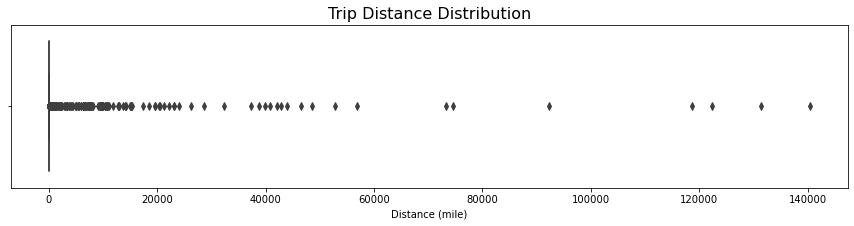

In [56]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df, x='trip_distance')
plt.xlabel('Distance (mile)')
plt.title('Trip Distance Distribution', fontsize=16)

plt.show()

In [57]:
df['trip_distance'].describe()

count   32448689.00
mean           3.63
std           65.44
min            0.01
25%            1.09
50%            1.80
75%            3.42
max       140385.20
Name: trip_distance, dtype: float64

 * Trips with 0.01 mile might be an error of the meter or trips initiated and canceled, thus we are not interested in them
 
* Trips with 14,0385 miles might be a data entry error or trip outside of NYC we are only interested in city wide trips.

In [67]:
print('Trips with less than 0.01 miles distance', len(df[df['trip_distance']==0.01]))
print('Trips with less than 1 miles or less distance', len(df[df['trip_distance']<=1]))
print('Trips with less than 3.42 miles or less distance', len(df[df['trip_distance']<=3.42]))


Trips with less than 0.01 miles distance 22133
Trips with less than 1 miles or less distance 7305361
Trips with less than 3.42 miles or less distance 24346630


In [88]:
print('Trips with more than 100 miles  distance', len(df[df['trip_distance']>=100]))
print('Trips with less than 10000 miles or less distance', len(df[df['trip_distance']>=10000]))
print('Trips with more than 50 miles  distance', len(df[df['trip_distance']>=50]))
print('Trips with less than 20 miles or less distance', len(df[df['trip_distance']>=20]))


Trips with more than 100 miles  distance 634
Trips with less than 10000 miles or less distance 0
Trips with more than 50 miles  distance 4830
Trips with less than 20 miles or less distance 373528


In [90]:
df['trip_distance'] = df['trip_distance'].clip(lower = 0.99, upper=100)

In [91]:
df['trip_distance'].describe()

count   32448689.00
mean           3.58
std            4.55
min            0.99
25%            1.09
50%            1.80
75%            3.42
max          100.00
Name: trip_distance, dtype: float64

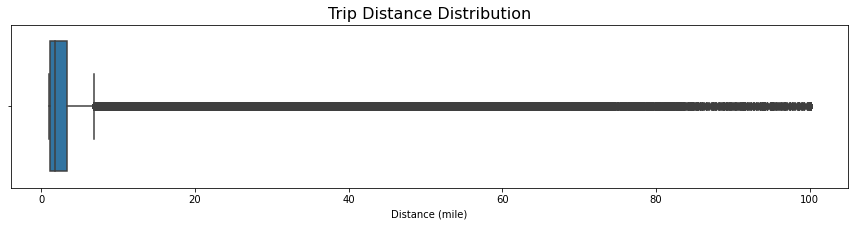

In [92]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df, x='trip_distance')
plt.xlabel('Distance (mile)')
plt.title('Trip Distance Distribution', fontsize=16)

plt.show()

we can still see some outliers for trip distance up to 100, based on domain knowledge maximum distance from city to airport which is what we are interested in is 20 miles thus we can cap again up to 30 not to remove all theoutliers and overfit the data.

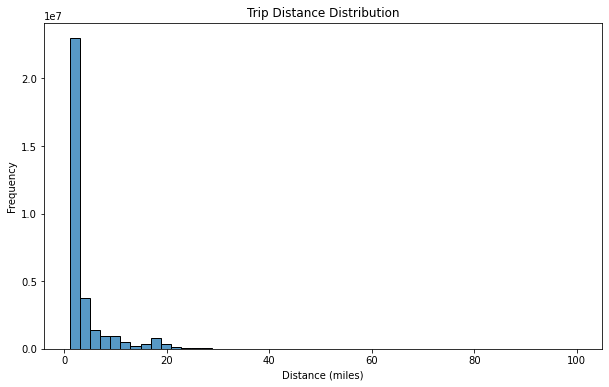

In [94]:
plt.figure(figsize=(10, 6))
sns.histplot(df['trip_distance'], bins=50, kde=False)
plt.title('Trip Distance Distribution')
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.show()

In [95]:
df['trip_distance'] = df['trip_distance'].clip(lower = 1, upper=30)

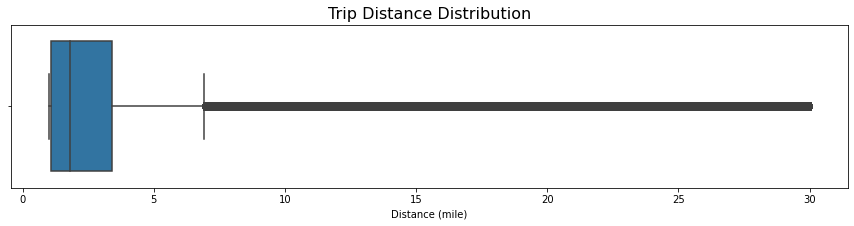

In [96]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df, x='trip_distance')
plt.xlabel('Distance (mile)')
plt.title('Trip Distance Distribution', fontsize=16)

plt.show()

In [97]:
# Define the bins and labels for trip distance categories
bins_of_distance = [0, 2, 5, 10, 20, 30]  # Adjusted to include 1-mile increments and cap at 30 miles
labels_of_distance = ['<2 miles', '2-5 miles', '6-10 miles', '11-20 miles', '21-30 miles']  # Updated labels to match bins

# Categorize 'trip_distance' using the defined bins and labels
df['distance_bins'] = pd.cut(df['trip_distance'], bins=bins_of_distance, labels=labels_of_distance, include_lowest=True)

# Count the frequency of trips in each distance category
distance_bin_counts = df['distance_bins'].value_counts().sort_index()

# Display the frequency of trips in each distance category
distance_bin_counts


<2 miles       17979003
2-5 miles       8820769
6-10 miles      2779431
11-20 miles     2500428
21-30 miles      369058
Name: distance_bins, dtype: int64

### Amount


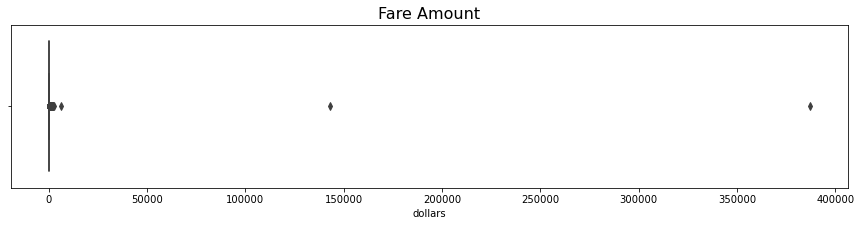

In [98]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df, x='fare_amount')
plt.xlabel('dollars')
plt.title('Fare Amount', fontsize=16)

plt.show()

In [99]:
df['fare_amount'].describe()

count   32448689.00
mean          19.75
std           74.67
min            0.01
25%            9.30
50%           13.50
75%           21.90
max       386983.63
Name: fare_amount, dtype: float64

In [101]:
df['fare_amount'] = df['fare_amount'].clip(lower = 1, upper= 500)

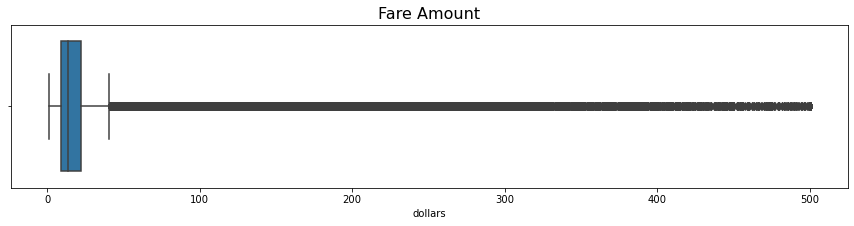

In [102]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df, x='fare_amount')
plt.xlabel('dollars')
plt.title('Fare Amount', fontsize=16)

plt.show()

In [109]:
print('Trips with more than 100 $  fare amount', len(df[df['fare_amount']>=100]))

Trips with more than 100 $  fare amount 102703


In [110]:
df['fare_amount'] = df['fare_amount'].clip(lower = 1, upper= 300)

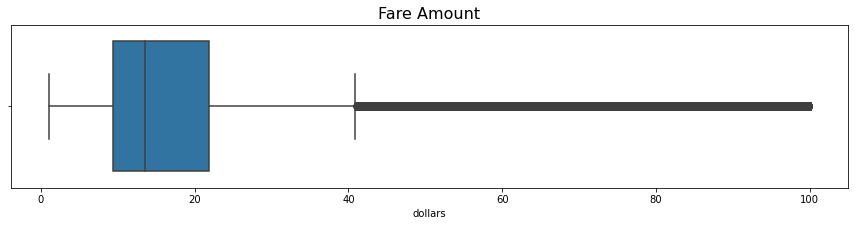

In [111]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df, x='fare_amount')
plt.xlabel('dollars')
plt.title('Fare Amount', fontsize=16)

plt.show()

## Other Features


In [112]:
df.describe()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,General_Airport_Fee,JFK_LGA_Pickup_Fee
count,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00
mean,1.39,3.57,19.60,1.61,0.50,3.59,0.60,1.00,28.93,2.32,0.14,0.01
std,0.88,4.46,16.99,1.83,0.04,4.04,2.18,0.01,75.94,0.64,0.46,0.11
min,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00
25%,1.00,1.09,9.30,0.00,0.50,1.00,0.00,1.00,15.96,2.50,0.00,0.00
50%,1.00,1.80,13.50,1.00,0.50,2.88,0.00,1.00,21.00,2.50,0.00,0.00
75%,1.00,3.42,21.90,2.50,0.50,4.48,0.00,1.00,30.72,2.50,0.00,0.00
max,6.00,30.00,100.00,96.38,53.16,711.88,665.56,1.00,386987.63,2.75,1.75,1.25


## Data Cleaning Continued 

* Removing or correcting outliers: Especially in columns like fare_amount, trip_distance, and others where you've noticed extreme values.
* Dealing with duplicates: If applicable, check for and remove duplicate records to ensure the integrity of your analysis.
* Further handling of NaN values: Based on the strategy you decide (removal, imputation, etc.), consistently apply it across relevant features.


In [113]:
# Define initial thresholds

df['total_amount'] = df['total_amount'].clip(lower=0, upper=500)
df['tip_amount'] = df['tip_amount'].clip(lower=0, upper= 500)


In [114]:
df['extra'] = df['extra'].clip(lower=0, upper=50)
df['mta_tax'] = df['mta_tax'].clip(lower=0.50, upper=0.60)
df['tolls_amount'] = df['tolls_amount'].clip(lower=0, upper=50)
df['improvement_surcharge'] = df['improvement_surcharge'].clip(lower=1.00, upper=1.00)
df['congestion_surcharge'] = df['congestion_surcharge'].clip(lower=2.50, upper=2.75)
df['General_Airport_Fee'] = df['General_Airport_Fee'].clip(lower=0, upper=1.75)
df['JFK_LGA_Pickup_Fee'] = df['JFK_LGA_Pickup_Fee'].clip(lower=0, upper=1.25)

### Results

In [115]:
df.describe()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,General_Airport_Fee,JFK_LGA_Pickup_Fee
count,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00,32448689.00
mean,1.39,3.57,19.60,1.61,0.50,3.59,0.60,1.00,28.91,2.50,0.14,0.01
std,0.88,4.46,16.99,1.83,0.00,4.04,2.18,0.00,22.74,0.00,0.46,0.11
min,1.00,1.00,1.00,0.00,0.50,0.00,0.00,1.00,0.01,2.50,0.00,0.00
25%,1.00,1.09,9.30,0.00,0.50,1.00,0.00,1.00,15.96,2.50,0.00,0.00
50%,1.00,1.80,13.50,1.00,0.50,2.88,0.00,1.00,21.00,2.50,0.00,0.00
75%,1.00,3.42,21.90,2.50,0.50,4.48,0.00,1.00,30.72,2.50,0.00,0.00
max,6.00,30.00,100.00,50.00,0.60,500.00,50.00,1.00,500.00,2.75,1.75,1.25


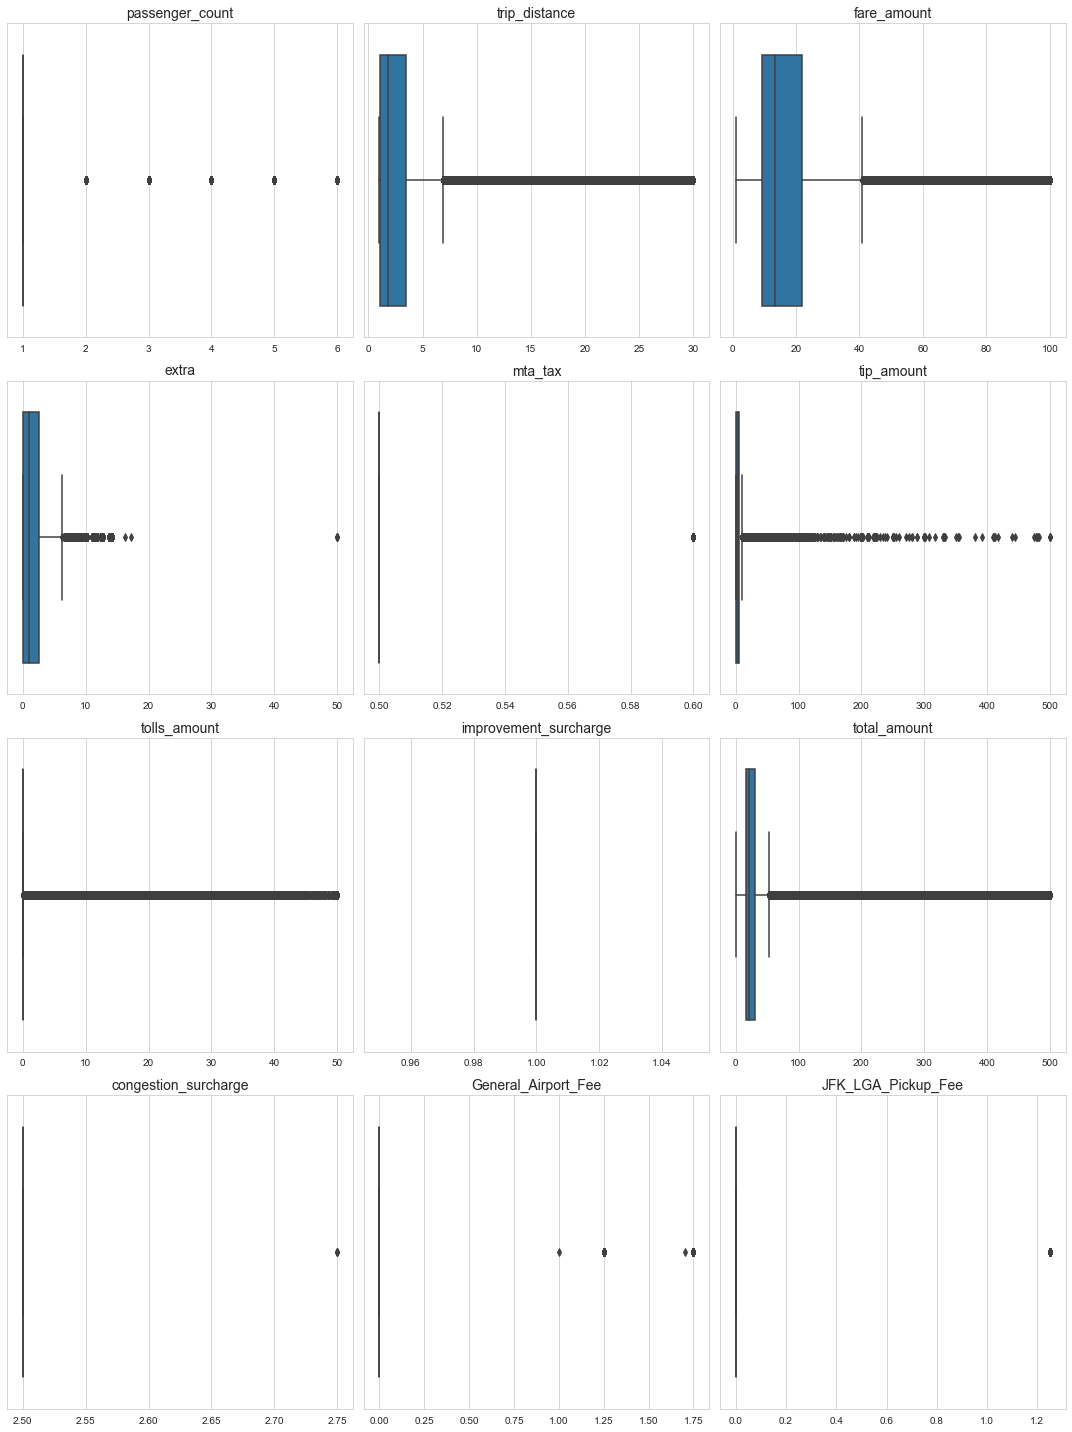

In [116]:

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# List of columns to plot
columns = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
           'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
           'congestion_surcharge', 'General_Airport_Fee', 'JFK_LGA_Pickup_Fee']

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))

# Flatten the array of axes for easy iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(col, fontsize=14)
    axes[i].set_xlabel('')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
f['total_amount'] = df['total_amount'].clip(lower=0, upper=500)
df['tip_amount'] = df['tip_amount'].clip(lower=0, upper= 500)

In [ ]:

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# List of columns to plot
columns = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
           'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
           'congestion_surcharge', 'General_Airport_Fee', 'JFK_LGA_Pickup_Fee']

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))

# Flatten the array of axes for easy iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(col, fontsize=14)
    axes[i].set_xlabel('')

# Adjust layout
plt.tight_layout()
plt.show()

As we can see there are still some outliers i total amount tip amount extras and trip distance. 

Based on the box plots provided, we can infer the following about the data:

1. **Passenger Count**: Outliers are not significant here, as all counts are within an expected range (0 to 6 passengers).

2. **Trip Distance**: Most data points are clustered near the lower end, but there are a few extreme outliers. Since the maximum distance has already been capped at 50 miles, which seems reasonable for a taxi trip, you could leave these outliers if they represent legitimate long-distance trips, or further investigate if there are errors in data entry.

3. **Fare Amount**: This looks fairly normal except for a few extreme outliers. These outliers may need to be investigated or capped further if they are unrealistic.

4. **Extra**: There are a few outliers which are significantly higher than the main distribution of the data. You may consider capping this based on a reasonable expectation of charges (e.g., nighttime or peak hour surcharges).

5. **MTA Tax**: The data is tightly concentrated around $0.50, with no visible outliers. This appears to be correctly capped already.

6. **Tip Amount**: The outliers stretch significantly, indicating very large tips. But removing them wont do any good as we already capped tips to remove all the largest outliers.

7. **Tolls Amount**: While there are outliers, if they correspond to actual tolls paid on long-distance trips, they may be legitimate. 

8. **Improvement Surcharge**: All data points are at $1.00, as expected.

9. **Total Amount**: There are outliers present. but the outliers ar ebound within 200$ fares which is legitamte for airport trips and long distance trips.

10. **Congestion Surcharge**: The congestion surcharge is tightly clustered around $2.50, with no outliers.

11. **General Airport Fee**: There are outliers present that are significantly higher than the standard fee. Further investigation into these outliers is necessary.

12. **JFK_LGA_Pickup Fee**: Most values are clustered around zero, with a few outliers. If the outliers don't make sense based on domain knowledge (e.g., fees higher than the regulated airport pickup fees), they should be addressed.



In [ ]:
df.head(1)

# Feature Engineering

It seems you are ready to progress to more advanced stages of your data analysis. Here are some steps you can take:

1. **Feature Engineering**: Introduce new features that could be significant for the model:
    - **Time of Day**: Create a new feature based on the `tpep_pickup_datetime` and `tpep_dropoff_datetime` that categorizes each trip into time slots such as morning, afternoon, evening, and night.
    - **Seasons**: Add a feature for the season of the year the trip took place in.
    - **Passenger Count Categories**: Classify the `passenger_count` into categories like low (1), medium (2-4), and high (5-6).
    - **Weekday/Weekend**: Determine whether the trip took place on a weekday or weekend.

2. **Standardization and Normalization**: If your model requires it, scale your features to have a mean of 0 and a standard deviation of 1, or normalize them to be between 0 and 1.

3. **Correlation Check**: Use Pearson or Spearman correlation to check how strongly your features are related to the target variable (`fare_amount`), and to each other, which can help in reducing multicollinearity.

4. **Segmentation**: Consider creating segments within your data based on geography (zones), time (rush hour, non-rush hours), and trip types (airport, non-airport) for more targeted analysis.

5. **Handling Missing Values and Duplicates**: Ensure that all missing values are handled appropriately (whether filled or dropped), and remove any duplicates to clean the dataset.

6. **Visualization**: Use visual tools like box plots and histograms to understand distributions and outliers after feature engineering.

7. **Hypothesis Testing**: If there are specific assumptions or hypotheses you want to test (like the impact of weather on fares), this would be the time to conduct such tests using statistical methods.

8. **Model Training and Validation**: Start with simpler models and gradually move to more complex ones. Use cross-validation to assess model performance and avoid overfitting.



In [ ]:
# Convert the pickup and dropoff datetime to pandas datetime format if not already
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Time of day segmentation
df['pickup_time_of_day'] = df['tpep_pickup_datetime'].dt.hour.apply(lambda x: 'morning' if 5 <= x <= 11
                                                                           else 'afternoon' if 12 <= x <= 17
                                                                           else 'evening' if 18 <= x <= 23
                                                                           else 'night')

# Seasons segmentation
df['pickup_season'] = df['tpep_pickup_datetime'].dt.month.apply(lambda x: 'spring' if 3 <= x <= 5
                                                                       else 'summer' if 6 <= x <= 8
                                                                       else 'autumn' if 9 <= x <= 11
                                                                       else 'winter')

# Passenger count categories
df['passenger_count_category'] = pd.cut(df['passenger_count'], bins=[0, 1, 4, 6], include_lowest=True, 
                                        labels=['low', 'medium', 'high'])

# Weekday/Weekend segmentation
df['pickup_day_type'] = df['tpep_pickup_datetime'].dt.day_name().apply(lambda x: 'weekend' if x in ['Saturday', 'Sunday'] else 'weekday')

# Check for US federal holidays
cal = calander()


In [ ]:
# Check if 'pickup_season' is correctly categorized
season_counts = df['pickup_season'].value_counts()
print(season_counts)

# Check if 'pickup_time_of_day' is correctly categorized
time_of_day_counts = df['pickup_time_of_day'].value_counts()
print(time_of_day_counts)

# Check if 'pickup_day_type' is correctly categorized for weekdays and weekends
day_type_counts = df['pickup_day_type'].value_counts()
print(day_type_counts)

# To check all together
summary = df.groupby(['pickup_day_type', 'pickup_time_of_day', 'pickup_season'])['fare_amount'].count()
print(summary)


In [ ]:
# Plotting the distribution of pickups by season
plt.figure(figsize=(10, 5))
sns.countplot(x='pickup_season', data=df)
plt.title('Pickup Distribution by Season')
plt.show()

# Plotting the distribution of pickups by time of day
plt.figure(figsize=(10, 5))
sns.countplot(x='pickup_time_of_day', data=df, order=['morning', 'afternoon', 'evening', 'night'])
plt.title('Pickup Distribution by Time of Day')
plt.show()

# Plotting the distribution of pickups by day type
plt.figure(figsize=(10, 5))
sns.countplot(x='pickup_day_type', data=df, order=['weekday', 'weekend'])
plt.title('Pickup Distribution by Day Type')
plt.show()


In [ ]:


# Summary statistics for the newly created categorical features
print(df[['pickup_time_of_day', 'pickup_season', 'passenger_count_category', 'pickup_day_type']].describe())

# Distribution of fares
plt.figure(figsize=(10, 5))
sns.histplot(df['fare_amount'], bins=30, kde=True)
plt.title('Distribution of Fare Amounts')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

# Fares over time of day
plt.figure(figsize=(10, 5))
sns.boxplot(x='pickup_time_of_day', y='fare_amount', data=df)
plt.title('Fare Amount by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Fare Amount')
plt.show()

# Fares by season
plt.figure(figsize=(10, 5))
sns.boxplot(x='pickup_season', y='fare_amount', data=df)
plt.title('Fare Amount by Season')
plt.xlabel('Season')
plt.ylabel('Fare Amount')
plt.show()

# Fares by passenger count categories
plt.figure(figsize=(10, 5))
sns.boxplot(x='passenger_count_category', y='fare_amount', data=df)
plt.title('Fare Amount by Passenger Count Category')
plt.xlabel('Passenger Count Category')
plt.ylabel('Fare Amount')
plt.show()

# Fares by day type
plt.figure(figsize=(10, 5))
sns.boxplot(x='pickup_day_type', y='fare_amount', data=df)
plt.title('Fare Amount by Day Type')
plt.xlabel('Day Type')
plt.ylabel('Fare Amount')
plt.show()


In [ ]:
# Trip data provided
trip_data = {
    '2023-06': 3307234,
    '2023-07': 2907108,
    '2023-05': 3513649,
    '2023-04': 3288250,
    '2023-08': 2824209,
    '2023-11': 3339715,
    '2023-01': 3066766,
    '2023-10': 3522285,
    '2023-09': 2846722,
    '2023-12': 3376567,
    '2023-02': 2913955,
    '2023-03': 3403766
}

# Create DataFrame for plotting
plot_data = pd.DataFrame(list(trip_data.items()), columns=['Month_Year', 'Trip_Counts'])
plot_data['Month_Year'] = pd.to_datetime(plot_data['Month_Year'])
plot_data.sort_values('Month_Year', inplace=True)
plot_data['Month_Year'] = plot_data['Month_Year'].dt.strftime('%Y-%m')  # Formatting for nicer axis labels


In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(plot_data['Month_Year'], plot_data['Trip_Counts'], color='skyblue')
plt.xlabel('Month-Year')
plt.ylabel('Number of Trips')
plt.title('Number of Trips Recorded Per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

# Assuming 'plot_data' is your DataFrame prepared previously
plot_data['Month_Year'] = pd.to_datetime(plot_data['Month_Year'])
plot_data.sort_values('Month_Year', inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(plot_data['Month_Year'], plot_data['Trip_Counts'], color='skyblue', label='Monthly Trips')
plt.xlabel('Month-Year')
plt.ylabel('Number of Trips')
plt.title('Number of Trips Recorded Per Month')

# Calculate and plot a trendline
z = np.polyfit(mdates.date2num(plot_data['Month_Year']), plot_data['Trip_Counts'], 1)
p = np.poly1d(z)
plt.plot(plot_data['Month_Year'], p(mdates.date2num(plot_data['Month_Year'])), "r--", label='Trendline')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

No Clear Seasonal Trend: The number of trips doesn't show a clear and consistent pattern that rises and falls at regular intervals throughout the year, which is typically indicative of strong seasonality.
Monthly Variations: There are variations in the number of trips per month, but these do not appear to follow a simple seasonal pattern. For example, we do not see a continuous increase or decrease that corresponds with specific seasons.
Mid-Year Dip: There seems to be a dip in the number of trips around July and August. This could be due to various factors such as summer holidays when people might leave the city, or it could be a seasonal variation. However, without data from multiple years, it's difficult to attribute this dip to seasonality with certainty.
End-of-Year Increase: Towards the end of the year, there seems to be an increase in trips, particularly in December. This could be related to the holiday season, which typically sees an increase in travel and activities.
Stability in Other Months: Aside from the mid-year dip and end-of-year increase, the other months seem relatively stable, with no dramatic rises or falls in the number of trips.
Trendline: The red dashed trendline appears relatively flat, indicating that, overall, there isn't a strong increasing or decreasing trend across these months.
Your project aims to analyze the NYC yellow taxi trip dataset, specifically from 2021, to develop a predictive model for taxi fares that can be adapted for Tbilisi's taxi services. The goal is to create a structured and transparent fare system that can inform policy changes and technological adoption in Tbilisi, contributing to a more regulated taxi market.
From your abstract, it's clear that the NYC taxi dataset serves as a comprehensive, regulated example to contrast with the unregulated environment of Tbilisi, offering a structured framework for fare calculation with regulated fares based on distance, time, and additional surcharges. You plan to utilize machine learning techniques to predict fares by examining variables like trip distance, timing, and external conditions such as weather and public events.
In terms of seasonality, your abstract and introduction do not directly state that seasonality is a primary focus. However, the model aims to explore key features that impact fare variability, which might include seasonal factors. Given that demand for taxis can indeed be influenced by seasonality due to tourism trends, weather conditions, and public holidays, it might be beneficial to include seasonality as a feature in your predictive model.
Creating a seasonal feature involves categorizing data into seasons (spring, summer, autumn, winter) and analyzing how these categories correlate with fare amounts. If the data shows consistent patterns in trip demand across the same seasons year over year, it would justify including a seasonal feature in your model.
In summary, based on the provided overview, you should consider the following:
Include Seasonality if Relevant: If your initial EDA and literature review suggest that seasonal factors significantly affect taxi demand and fare prices in NYC, it would be reasonable to include a seasonal feature in your predictive model. This could then be considered in the context of Tbilisi when proposing policy changes or technological adaptations. Model Adaptation: When adapting your model to Tbilisi's context, remember that direct translations of seasonal impacts from NYC may not apply. Consider local seasonal factors that could affect Tbilisi differently, such as variations in weather, tourism patterns, and cultural events throughout the year. Comparative Analysis: Use the NYC model as a starting point and compare it with any available data from Tbilisi. If direct data on seasonality is not available for Tbilisi, use proxy indicators (e.g., tourism data, weather patterns) to hypothesize the potential seasonal effects on taxi demand and fares. Policy Implications: Your recommendations for Tbilisi should take into account the findings from the model, including any seasonal effects observed. Any policy or technological recommendations should be adaptable to the unique seasonal dynamics of the region.